In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection as GRP
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.stats import kurtosis

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix,f1_score, confusion_matrix,classification_report,accuracy_score,roc_auc_score,recall_score,mean_squared_error

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

<h1>Import Clean and Clustered Datasets</h1>

In [6]:
#Wine Data
data = pd.read_csv('../data/wineQualityDataset/WineQT.csv', sep=',')
#Drop id
data = data.drop("Id", axis=1)
#drop duplicate
data = data.drop_duplicates().reset_index(drop=True)

data = data.drop(data[data.quality == 3].index).reset_index(drop=True)
data = data.drop(data[data.quality == 4].index).reset_index(drop=True)
#data = data.drop(data[data.quality == 8].index).reset_index(drop=True)
data.loc[data["quality"] == 8, "quality"] = 7

#normalize the data
# Select numerical variables
data_X = data.drop("quality", axis=1)
# data_X = data_X.drop("Id", axis=1)
numeric = data_X.select_dtypes(exclude=object).columns
#numeric.remove('quality')
print(type(numeric))
for col in numeric:
    data_X[col] = StandardScaler().fit_transform(data_X[[col]])

data = data_X.join(data['quality'])

# #update y values
# data.loc[data["quality"] == 5, "quality"] = 0
# data.loc[data["quality"] == 6, "quality"] = 1
# data.loc[data["quality"] == 7, "quality"] = 2

#below vars are used.
data_W = data
wineX=data_W.drop("quality", 1).copy().values
winey= data_W[["quality"]]

<class 'pandas.core.indexes.base.Index'>


In [7]:

# cluster data and predict labels
kmeans = KMeans(n_clusters=7,init='k-means++', random_state=0)
kmeans.fit(wineX)
kmeans_labels = kmeans.predict(wineX)

# add in cluster labels as additional feature
kmeans_wineX = np.c_[wineX, kmeans_labels]


# cluster data and predict labels
em = GaussianMixture(n_components=6, random_state=0)
em.fit(wineX)
em_labels = em.predict(wineX)

# add in cluster labels as additional feature
em_wineX = np.c_[wineX, em_labels]


wine_data = []
wine_data.append(['Original', wineX])
wine_data.append(['Kmeans_clustered', kmeans_wineX])
wine_data.append(['EM_Clustered', em_wineX])


<h3>Helper Methods</h3>

In [8]:
# Function based on:
# https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
def plot_learning_curve(clf, X, y, title='Learning Curve'):
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
                                                        clf, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='recall',
                                                        # Use all computer cores
                                                        #n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        #train_sizes=np.linspace(0.01, 1.0, 10),
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        return_times = True,
                                                        #random_state = 0
                                                        )

#     _, train_scores, test_scores = learning_curve(clf_nn_l, X_train, y_train, train_sizes=train_sizes, scoring='recall', cv=5)

    # ------------------------------------------------------------------------------------------
    # Plot Learning Curve
    # ------------------------------------------------------------------------------------------
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    plt.figure(1)
    plt.plot(train_sizes, train_mean, '--', label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    # Create learning curve plot
    plt.title(title)
    plt.xlabel("Training Set Size"), plt.ylabel("Recall Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()
    
    # ------------------------------------------------------------------------------------------
    # Plot Scalability Curve
    # ------------------------------------------------------------------------------------------
    # Create mean and std of training times
    train_times_mean = np.mean(fit_times, axis=1)
    train_times_std  = np.std(fit_times, axis=1)
    
    # plot lines
    plt.figure(2)
    plt.plot(train_sizes, train_times_mean, 'o-')
    plt.fill_between(train_sizes, train_times_mean - train_times_std, train_times_mean + train_times_std, color='#DDDDDD')
    plt.title('Training Scalability')
    plt.xlabel('Training Set Size')
    plt.ylabel('Fit Times (s)')
    plt.grid()
    plt.show()
    
    
def plot_learning_curve2(clf, X_train, y_train, title='Learning curve for neural network'): 
    param_range=np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores, fit_times, score_times= learning_curve(clf_nn_best, X_train, y_train, train_sizes=param_range, return_times = True, scoring='f1_micro', cv=5)

    param_range=np.linspace(0.1, 1.0, 5)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="gainsboro")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="gainsboro")

    plt.title(title)
    plt.xlabel('Fraction of training examples')
    plt.ylabel("f1_micro score")
    plt.legend(loc="best")
    plt.grid()
#     plt.savefig('../images/wq/wq_nn_lc.png')
    plt.show()   
    
        # ------------------------------------------------------------------------------------------
    # Plot Scalability Curve
    # ------------------------------------------------------------------------------------------
    # Create mean and std of training times
    train_times_mean = np.mean(fit_times, axis=1)
    train_times_std  = np.std(fit_times, axis=1)
    
    # plot lines
    plt.figure(2)
    plt.plot(param_range, train_times_mean, 'o-')
    plt.fill_between(param_range, train_times_mean - train_times_std, train_times_mean + train_times_std, color='gainsboro')
    plt.title('Training Scalability')
    plt.xlabel('Training Set Size')
    plt.ylabel('Fit Times (s)')
    plt.grid()
    plt.show()
    
# Function based on:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(clf, X_test, y_test):
    
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        #print(title)
        #print(disp.confusion_matrix)
        plt.show()

    plt.show()
    
    return 0

def plot_loss_curve(classifier_neural_network, X_train, y_train, X_test, y_test, title='Loss Curve NN'):
    
#     classifier_neural_network = MLPClassifier(random_state=33, max_iter=1, learning_rate_init=best_clf_nn.best_params_['learning_rate_init'], hidden_layer_sizes=best_clf_nn.best_params_['hidden_layer_sizes'], warm_start=True)
    epochs = 300
    loss_training = np.zeros(epochs)
    score_training = np.zeros(epochs)
    score_validation = np.zeros(epochs)

    X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=33)
    for epoch in range(epochs):
        classifier_neural_network.fit(X_train_train, y_train_train)
    
        score_training[epoch] = f1_score(y_train_train, classifier_neural_network.predict(X_train_train), average='micro')
        score_validation[epoch] = f1_score(y_train_val, classifier_neural_network.predict(X_train_val), average='micro')
    
        loss_training[epoch] = classifier_neural_network.loss_
    
    score_test = f1_score(y_test, classifier_neural_network.predict(X_test), average='micro')
    print("f1_micro Score:", score_test)
    
    plt.figure(3)
    plt.plot(np.arange(epochs)+1, loss_training, label='Train Loss')
    plt.legend()
    plt.title(title)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Loss")
    plt.grid()
#     plt.savefig('../images/wq/wq_nn_loss_curve.png')
    plt.show()


<h1>Neural Network</h1>

-------------------------------------
Original
Neural Net model fit in 118.310 s
Best Score: 0.623 using {'hidden_layer_sizes': 4, 'learning_rate_init': 0.1}


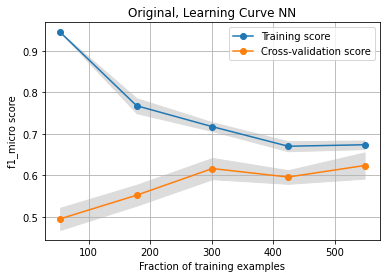

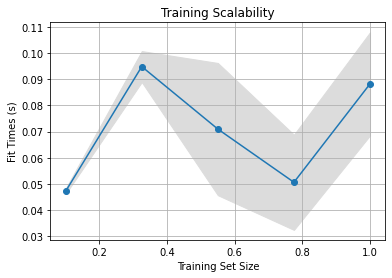

              precision    recall  f1-score   support

           5       0.75      0.62      0.68       141
           6       0.53      0.71      0.61       114
           7       0.76      0.49      0.59        39

    accuracy                           0.64       294
   macro avg       0.68      0.60      0.63       294
weighted avg       0.67      0.64      0.64       294



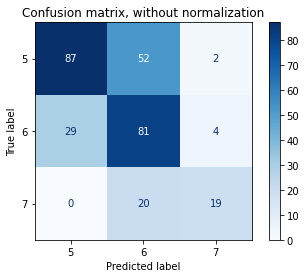

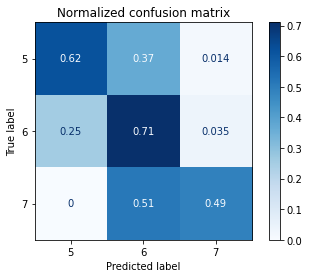

-------------------------------------
Kmeans_clustered
Neural Net model fit in 120.487 s
Best Score: 0.636 using {'hidden_layer_sizes': 2, 'learning_rate_init': 0.1}


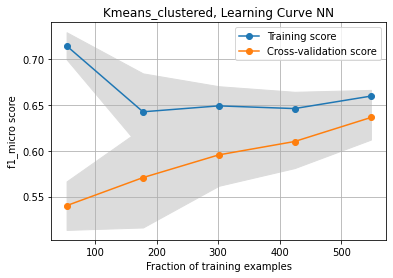

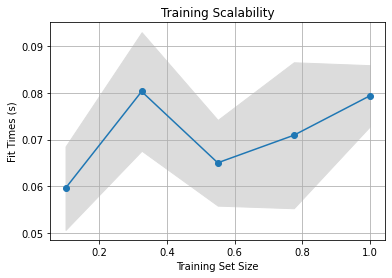

              precision    recall  f1-score   support

           5       0.74      0.64      0.69       141
           6       0.51      0.71      0.59       114
           7       0.85      0.28      0.42        39

    accuracy                           0.62       294
   macro avg       0.70      0.54      0.57       294
weighted avg       0.67      0.62      0.61       294



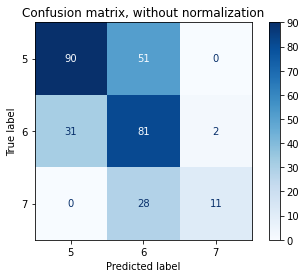

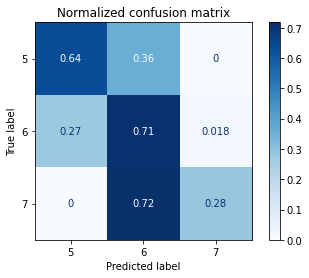

-------------------------------------
EM_Clustered
Neural Net model fit in 127.345 s
Best Score: 0.631 using {'hidden_layer_sizes': 2, 'learning_rate_init': 0.001}


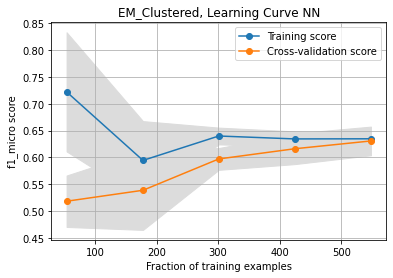

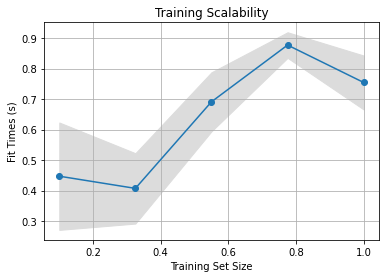

              precision    recall  f1-score   support

           5       0.72      0.62      0.66       141
           6       0.50      0.68      0.57       114
           7       0.74      0.36      0.48        39

    accuracy                           0.61       294
   macro avg       0.65      0.55      0.57       294
weighted avg       0.64      0.61      0.61       294



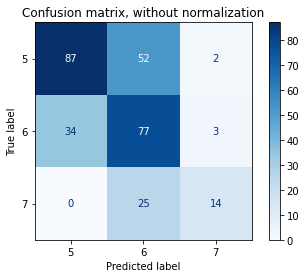

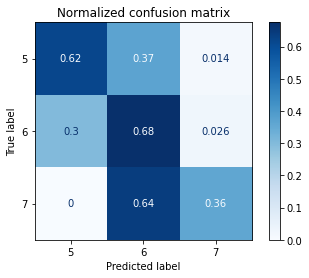

Results
Data:  Original
	Time:    118.30956435203552
	Score:   0.6233576642335767
	Params:  {'hidden_layer_sizes': 4, 'learning_rate_init': 0.1}
Data:  Kmeans_clustered
	Time:    120.48738598823547
	Score:   0.6364963503649635
	Params:  {'hidden_layer_sizes': 2, 'learning_rate_init': 0.1}
Data:  EM_Clustered
	Time:    127.34501814842224
	Score:   0.6306569343065693
	Params:  {'hidden_layer_sizes': 2, 'learning_rate_init': 0.001}


In [9]:
# Define Grid Search parameters
learning_rates = ['constant', 'invscaling']
solvers = ['sgd', 'lbfgs', 'adam']
layers = np.arange(1,6,1)
parameters = {'solver': solvers, 'learning_rate': learning_rates, 'hidden_layer_sizes': layers}

param_grid = {'learning_rate_init': np.logspace(-3, -1, 3), 'hidden_layer_sizes': np.arange(2,25,2)}


# define size of test set
test_size=0.3

# collect all results
nn_data = []

for d in wine_data:
    dataName = d[0]
    print('-------------------------------------')
    print(dataName)
    
    X = d[1]
    y = winey
    
#     # Scale the data
#     X = scale(X)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    
#     param_grid = {'max_depth': np.arange(1,20), 'ccp_alpha': np.linspace(0,0.01,8)}
#     clf_dt_g = GridSearchCV(clf_dt, param_grid=param_grid, scoring='f1_micro', cv=5)
    
#     clf = GridSearchCV(MLPClassifier(random_state=33),
#                        parameters,
#                        cv=5,
#                        scoring='f1_micro')
    clf= GridSearchCV(MLPClassifier(random_state=33, max_iter=2000), param_grid=param_grid, scoring='f1_micro', cv=5)
                
    t0 = time()
    clf.fit(X_train, y_train)
    nn_time = time() - t0
    
    print("Neural Net model fit in %.3f s" % nn_time)
    print('Best Score: %.3f using %r' % (clf.best_score_, clf.best_params_))
    
    # Create NN with best parameters from grid search
    train_sizes = np.linspace(0.1, 1.0, 5)
    clf_nn_best = MLPClassifier(random_state=33, max_iter=2000, hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'], learning_rate_init=clf.best_params_['learning_rate_init'])
   
    plot_learning_curve2(clf_nn_best, X_train, y_train, title= dataName + ', Learning Curve NN')
#     plot_loss_curve(clf_nn_best, X_train, y_train, X_test, y_test, title= dataName + ', Loss Curve NN')
    # Predict results using the test set
    clf_nn_best.fit(X_train, y_train)
    nn_pred = clf_nn_best.predict(X_test)
    
    
    # let's see how our model performed
    print(classification_report(y_test, nn_pred))
    
    plot_confusion(clf_nn_best, X_test, y_test)
    
    
    # Collect results
    results = {
        "classifier": clf_nn_best,
        "dataset": dataName,
        "time":    nn_time,
        "score":   clf.best_score_,
        "params":  clf.best_params_
    }
    
    nn_data.append(results)

print('Results')
for res in nn_data:
    print('Data: ',     res["dataset"])
    print('\tTime:   ', res["time"])
    print('\tScore:  ', res["score"])
    print('\tParams: ', res["params"])

Results
Data:  Original
	Time:    118.30956435203552
	Score:   0.6233576642335767
	Params:  {'hidden_layer_sizes': 4, 'learning_rate_init': 0.1}
Data:  Kmeans_clustered
	Time:    120.48738598823547
	Score:   0.6364963503649635
	Params:  {'hidden_layer_sizes': 2, 'learning_rate_init': 0.1}
Data:  EM_Clustered
	Time:    127.34501814842224
	Score:   0.6306569343065693
	Params:  {'hidden_layer_sizes': 2, 'learning_rate_init': 0.001}